# Import necessary libraries

In [2]:
import json
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt 
import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetRegressor


from scipy import stats

### Import Final dataset and Encodings for Categorical Data

In [3]:
final_data= pd.read_csv('data/clean_data/final_data.csv')

with open('data/clean_data/encoding_mappings.json', 'r') as fp:
    encoding_mappings = json.load(fp)


### Function for encoding mappings

In [5]:
def encode_new_input(new_input, encoding_mappings):
# If new_input is a dictionary, convert it to a DataFrame
    if isinstance(new_input, dict):
        new_input = pd.DataFrame([new_input])
    
    # If new_input is a list of dictionaries, convert it to a DataFrame
    elif isinstance(new_input, list):
        new_input = pd.DataFrame(new_input)

    # Ensure that new_input is a DataFrame at this point
    if not isinstance(new_input, pd.DataFrame):
        raise ValueError("new_input must be a pandas DataFrame, a dictionary, or a list of dictionaries.")    
    new_input_encoded = new_input.copy()
    for column, mapping in encoding_mappings.items():
        if column in new_input.columns:
            # Apply the mapping to the column
            new_input_encoded[column] = new_input[column].map(mapping)
            # Fill in NaN values if the category was not seen during training
            if new_input_encoded[column].isna().any():
                unknown_rank = np.median(list(mapping.values()))
                # Use direct assignment instead of inplace=True
                new_input_encoded[column] = new_input_encoded[column].fillna(unknown_rank)
    
    return new_input_encoded

### Features and Target Columns

In [6]:
features = ['Year','floor_area_sqm', 'lease_commence_date', 'average_storey','town', 'flat_type', 'flat_model']
target = 'resale_price'

### Splitting Dataset 

Ratio of split: 90 Train : 10 Test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(final_data[features], final_data[target], test_size=0.1, random_state=42)

### Log and Boxcox Transformation to fix skewness of data for target variable

In [35]:
#for linreg
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

#boxcox
y_train_boxcox, lambda_boxcox = stats.boxcox(y_train)
y_test_boxcox = stats.boxcox(y_test, lmbda=lambda_boxcox) 

### For XGBoost

### Split Train Data further
- Ratio of Split: 90 Train: 10 Valid for TabNet (Based on X-Trainand Y-Train)
- Apply Log and Boxcox transformation for Skewness
- Tabnet only takes Array as valid input so convert Dataframe to NdArray

In [36]:
#Tabnet
X_train_tabnet, X_valid_tabnet, y_train_tabnet, y_valid_tabnet = train_test_split(X_train, y_train, 
                                                                                          test_size=0.1, 
                                                                                          random_state=42)

X_train_tabnet_values = X_train_tabnet.values
X_valid_tabnet_values = X_valid_tabnet.values

#log transformation
y_train_tabnet_log_values = np.log(y_train_tabnet.values).reshape(-1, 1)
y_valid_tabnet_log_values = np.log(y_valid_tabnet.values).reshape(-1, 1)

#boxcox transformation
y_train_tabnet_box, lambda_boxcox_tabnet = stats.boxcox(y_train_tabnet)
y_valid_tabnet_box = stats.boxcox(y_valid_tabnet,lmbda=lambda_boxcox_tabnet)

y_train_tabnet_box_values = y_train_tabnet_box.reshape(-1,1)
y_valid_tabnet_box_values = y_valid_tabnet_box.reshape(-1,1)

## Fit Linear Regression Model

In [37]:
# Train a linear regression no Transformation
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Train a XGBoost model no Transformation
xgbreg = xgb.XGBRegressor(
    objective='reg:squarederror', 
    booster='gbtree', 
    reg_alpha=0.1, 
    reg_lambda=0.1)
xgbreg.fit(X_train,y_train)


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Fit Linear Regression Model with Log Transformation

In [38]:
# Train a linear regression model after log transformation
linreg_withLog = LinearRegression()
linreg_withLog.fit(X_train, y_train_log)

# Train a XGBoost model after log transformation
xgbreg_withLog = xgb.XGBRegressor(
    objective='reg:squarederror', 
    booster='gbtree', 
    reg_alpha=0.1, 
    reg_lambda=0.1)
xgbreg_withLog.fit(X_train,y_train_log)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Fit Linear Regression Model with BoxCox Transformation

In [39]:
# Train a linear regression model after boxcox transformation
linreg_withBoxCox = LinearRegression()
linreg_withBoxCox.fit(X_train, y_train_boxcox)

# Train a XGBoost model after boxcox transformation
xgbreg_withBoxCox = xgb.XGBRegressor(
    objective='reg:squarederror', 
    booster='gbtree', 
    reg_alpha=0.1, 
    reg_lambda=0.1)

xgbreg_withBoxCox.fit(X_train,y_train_boxcox)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Initialize and Train TabNet Regressor Model (Log Transformation)

In [115]:
# Train a tabnet model after log ransformation
tabnetReg_log = TabNetRegressor()
max_epochs = 200

tabnetReg_log.fit(
    X_train_tabnet_values, 
    y_train_tabnet_log_values,
    eval_set=[(X_train_tabnet_values, y_train_tabnet_log_values), 
              (X_valid_tabnet_values, y_valid_tabnet_log_values)],
    eval_name=['train', 'valid'],
    eval_metric=['mae','rmse'],
    max_epochs = 200,
    patience = 10,
    batch_size = 8192,
    virtual_batch_size = 1024,
    num_workers = 0,
    drop_last=False
)

/Users/kur0/Documents/Year1/sc1015_lab/SC1015_Mini_Proj/.mini/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 14.10072| train_mae: 8.83584 | train_rmse: 20.21968| valid_mae: 9.01451 | valid_rmse: 20.51155|  0:00:08s
epoch 1  | loss: 0.07777 | train_mae: 9.38273 | train_rmse: 12.79048| valid_mae: 9.35815 | valid_rmse: 12.77694|  0:00:16s
epoch 2  | loss: 0.04736 | train_mae: 4.23959 | train_rmse: 6.62588 | valid_mae: 4.21435 | valid_rmse: 6.58938 |  0:00:26s
epoch 3  | loss: 0.03794 | train_mae: 1.22004 | train_rmse: 2.08255 | valid_mae: 1.22233 | valid_rmse: 2.09194 |  0:00:34s
epoch 4  | loss: 0.03734 | train_mae: 0.70483 | train_rmse: 0.98548 | valid_mae: 0.70678 | valid_rmse: 0.99128 |  0:00:42s
epoch 5  | loss: 0.03569 | train_mae: 0.78985 | train_rmse: 1.00773 | valid_mae: 0.79367 | valid_rmse: 1.00993 |  0:00:50s
epoch 6  | loss: 0.03449 | train_mae: 0.54672 | train_rmse: 0.65502 | valid_mae: 0.54754 | valid_rmse: 0.65604 |  0:00:59s
epoch 7  | loss: 0.03024 | train_mae: 0.39841 | train_rmse: 0.47986 | valid_mae: 0.39889 | valid_rmse: 0.48055 |  0:01:08s
epoch 8  | loss:

/Users/kur0/Documents/Year1/sc1015_lab/SC1015_Mini_Proj/.mini/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## Initialize and Train TabNet Regressor Model (BoxCox Transformation)

In [116]:
# Train a tabnet model after boxcox ransformation
tabnetReg_box = TabNetRegressor()
max_epochs = 200

tabnetReg_box.fit(
    X_train_tabnet_values, 
    y_train_tabnet_box_values,
    eval_set=[(X_train_tabnet_values, y_train_tabnet_box_values), 
              (X_valid_tabnet_values, y_valid_tabnet_box_values)],
    eval_name=['train', 'valid'],
    eval_metric=['mae','rmse'],
    max_epochs = 200,
    patience = 20,
    batch_size = 8192,
    virtual_batch_size = 1024,
    num_workers = 0,
    drop_last=False
)

/Users/kur0/Documents/Year1/sc1015_lab/SC1015_Mini_Proj/.mini/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 515.85951| train_mae: 68.08491| train_rmse: 150.66813| valid_mae: 68.96451| valid_rmse: 151.72444|  0:00:09s
epoch 1  | loss: 2.63046 | train_mae: 7.44543 | train_rmse: 8.17059 | valid_mae: 7.43674 | valid_rmse: 8.16611 |  0:00:18s
epoch 2  | loss: 1.81714 | train_mae: 7.65977 | train_rmse: 8.34715 | valid_mae: 7.64751 | valid_rmse: 8.33939 |  0:00:28s
epoch 3  | loss: 1.69866 | train_mae: 8.03778 | train_rmse: 8.66701 | valid_mae: 8.02532 | valid_rmse: 8.65828 |  0:00:37s
epoch 4  | loss: 1.64963 | train_mae: 7.64408 | train_rmse: 8.27176 | valid_mae: 7.63066 | valid_rmse: 8.26184 |  0:00:46s
epoch 5  | loss: 1.64706 | train_mae: 7.97918 | train_rmse: 8.5889  | valid_mae: 7.97061 | valid_rmse: 8.58392 |  0:00:55s
epoch 6  | loss: 1.55713 | train_mae: 7.28667 | train_rmse: 7.84709 | valid_mae: 7.28041 | valid_rmse: 7.84664 |  0:01:05s
epoch 7  | loss: 1.4619  | train_mae: 4.35294 | train_rmse: 4.75205 | valid_mae: 4.34706 | valid_rmse: 4.74561 |  0:01:14s
epoch 8  | lo

/Users/kur0/Documents/Year1/sc1015_lab/SC1015_Mini_Proj/.mini/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## Valid Root Mean Square Error vs Epochs (Log Tranformation)

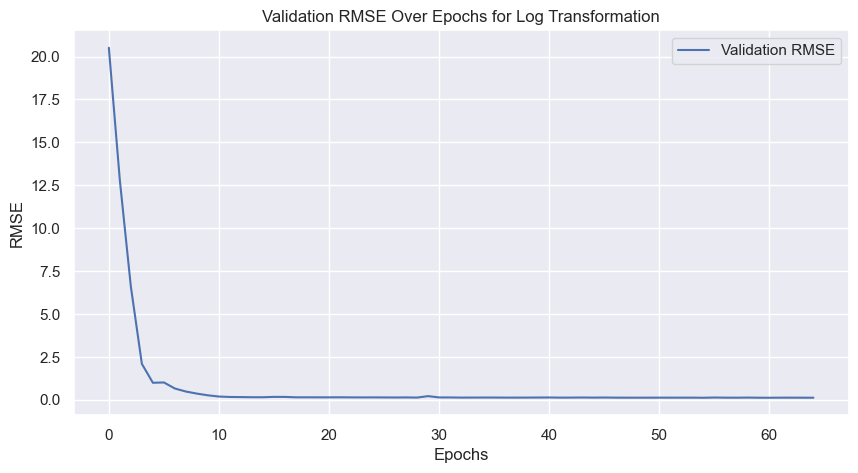

In [124]:
valid_rmse_log = tabnetReg_log.history['valid_rmse']

epochs = range(len(valid_rmse_log))

plt.figure(figsize=(10,5))
plt.plot(epochs, valid_rmse_log, label='Validation RMSE')
plt.title('Validation RMSE Over Epochs for Log Transformation')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

## Valid Root Mean Square Error vs Epochs (BoxCox Tranformation)

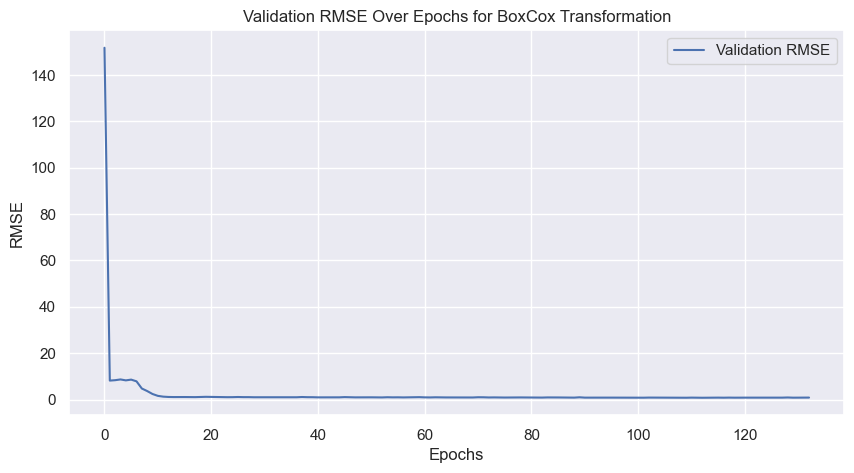

In [125]:
valid_rmse_box = tabnetReg_box.history['valid_rmse']

epochs = range(len(valid_rmse_box))

plt.figure(figsize=(10,5))
plt.plot(epochs, valid_rmse_box, label='Validation RMSE')
plt.title('Validation RMSE Over Epochs for BoxCox Transformation')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [126]:
#default
linear_regression_coefficients = linreg.coef_
linear_regression_intercept = linreg.intercept_
xgboost_feature_importances = xgbreg.feature_importances_

#log
linear_regression_withlog_coefficients = linreg_withLog.coef_
linear_regression_withlog_intercept = linreg_withLog.intercept_
xgboost_withLog_feature_importances = xgbreg_withLog.feature_importances_
tabnetlog_feature_importances = tabnetReg_log.feature_importances_

#boxcox
linear_regression_withbox_coefficients = linreg_withBoxCox.coef_
linear_regression_withbox_intercept = linreg_withBoxCox.intercept_
xgboost_withBox_feature_importances = xgbreg_withBoxCox.feature_importances_
tabnetbox_feature_importances = tabnetReg_box.feature_importances_

## Analysis of Importance of Features Amongst Models

In [127]:
# Create a DataFrame to hold the feature importances
df_feature_importance = pd.DataFrame({
    'Feature': features,
    'Linear Regression': linear_regression_coefficients,
    'Linear Regression (with log transformation)': linear_regression_withlog_coefficients,
    'Linear Regression (with boxcox transformation)': linear_regression_withbox_coefficients,
    'XGBoost': xgboost_feature_importances,
    'XGBoost (with log transformation)': xgboost_withLog_feature_importances,
    'XGBoost (with boxcox transformation)': xgboost_withBox_feature_importances,
    'TabNet (with log transformation)': tabnetlog_feature_importances,
    'TabNet (with boxcox transformation)': tabnetbox_feature_importances
})

df_feature_importance


,Feature,Linear Regression,Linear Regression (with log transformation),Linear Regression (with boxcox transformation),XGBoost,XGBoost (with log transformation),XGBoost (with boxcox transformation),TabNet (with log transformation),TabNet (with boxcox transformation)
0,Year,13359.502731,0.038821,0.316677,0.238359,0.320313,0.305752,0.163128,0.059609
1,floor_area_sqm,1633.707530,0.006758,0.052126,0.092569,0.170352,0.167918,0.067607,0.048271
2,lease_commence_date,501.474439,0.002018,0.015568,0.022847,0.016300,0.018376,0.104881,0.062539
3,average_storey,5852.166528,0.012708,0.108569,0.041062,0.030666,0.031473,0.060658,0.111083
4,town,616.057778,0.003372,0.025820,0.028548,0.027907,0.030961,0.268886,0.405642
5,flat_type,35732.344795,0.073801,0.648184,0.496019,0.398669,0.396175,0.129409,0.254836
6,flat_model,5316.897547,0.003483,0.044308,0.080595,0.035793,0.049344,0.205431,0.058020


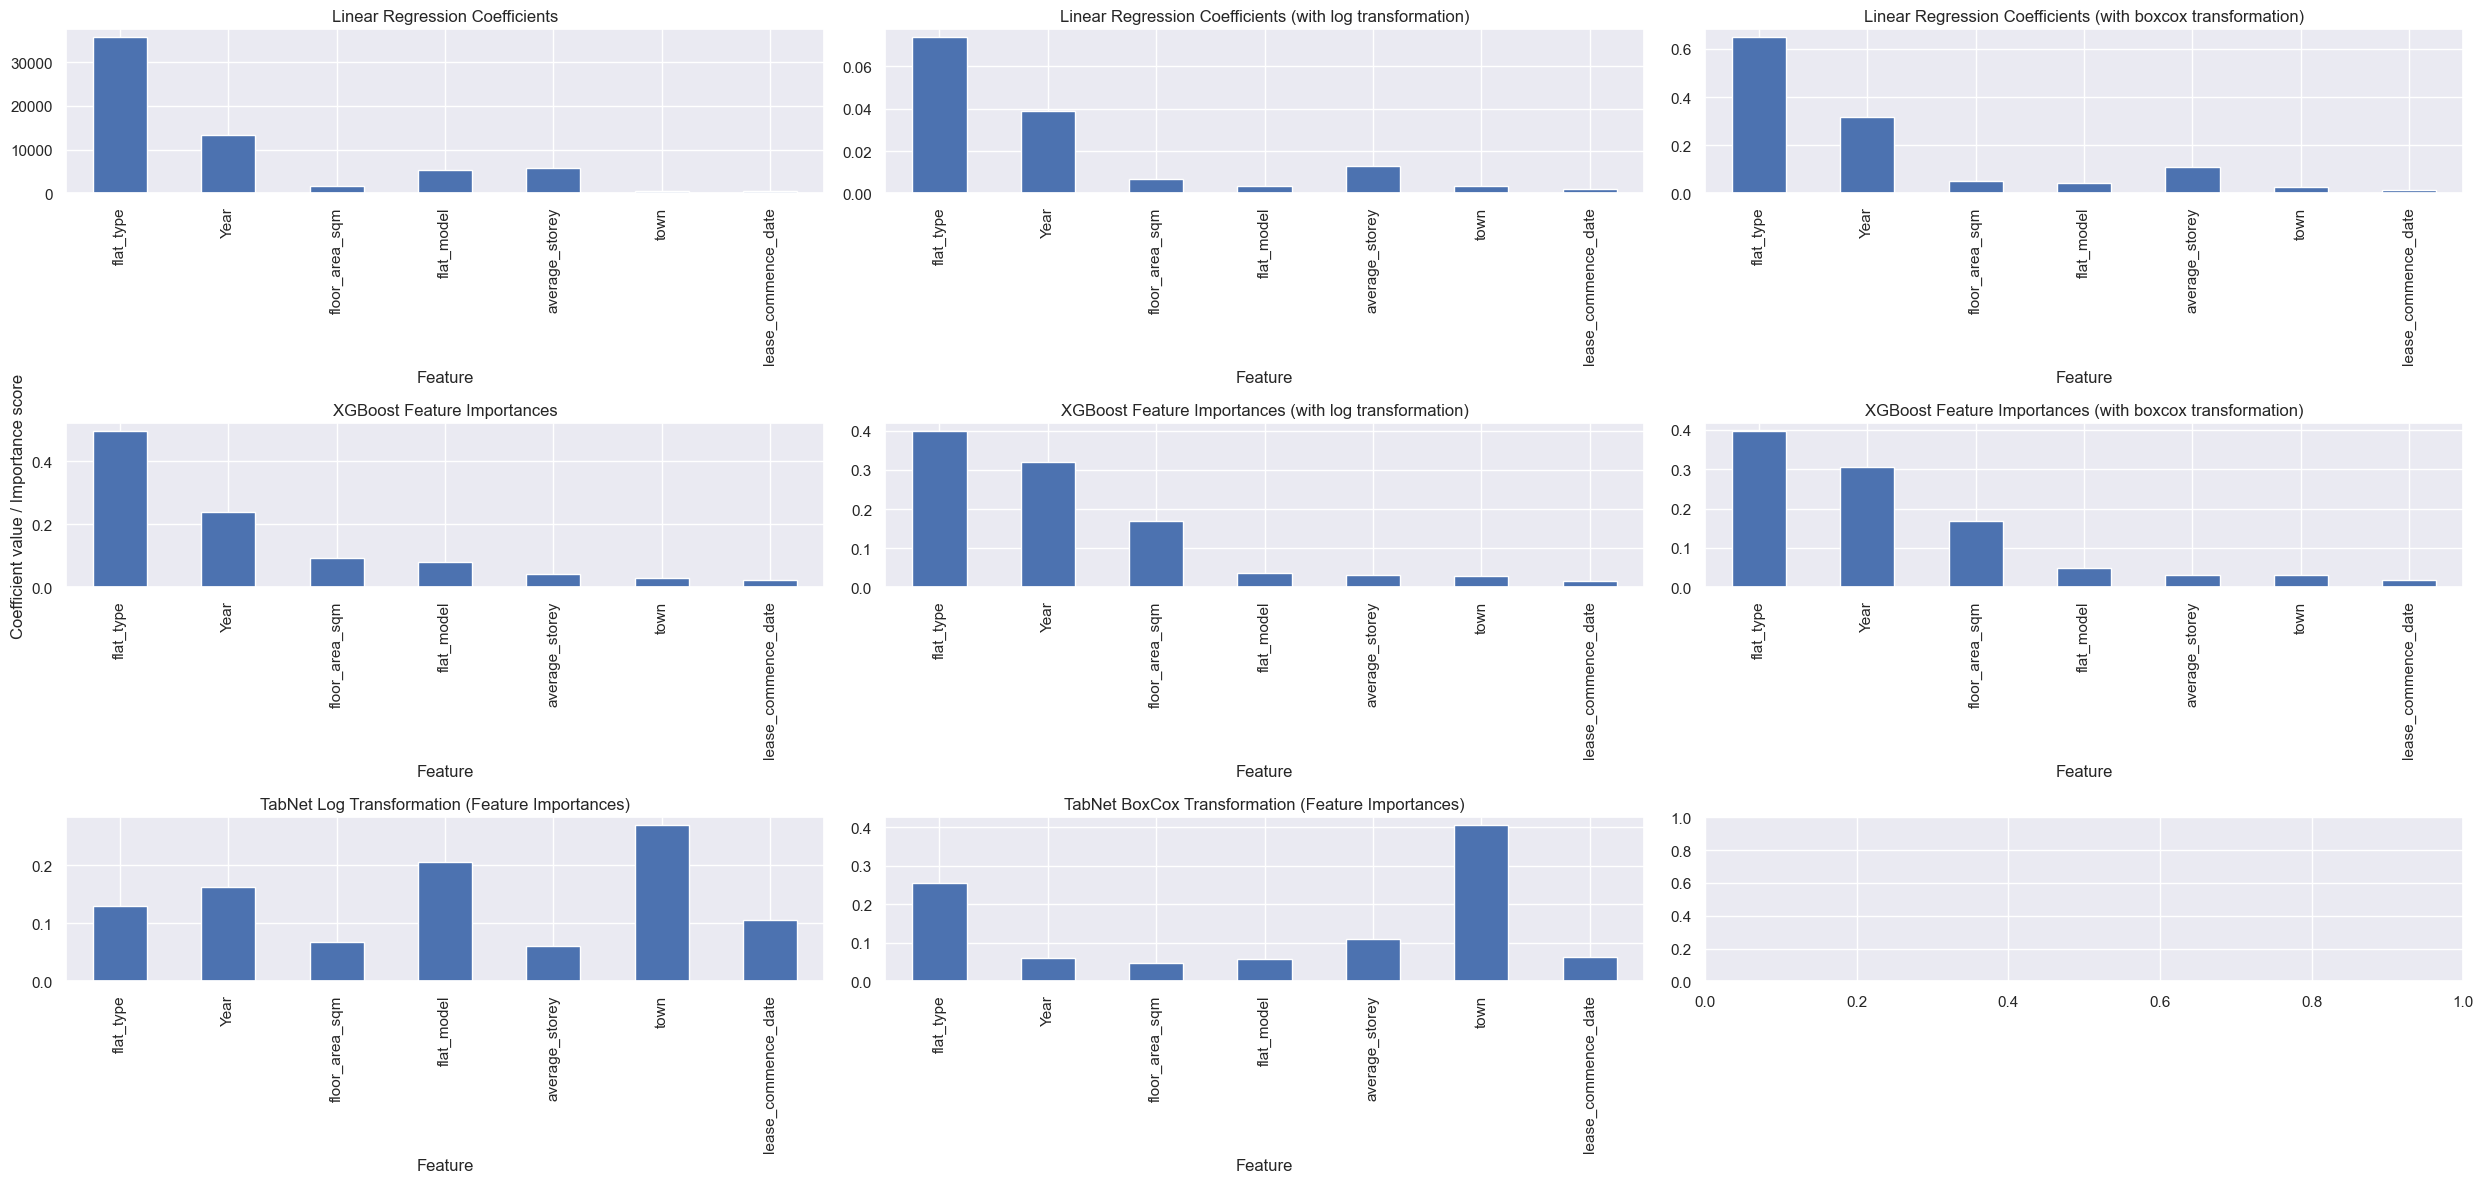

In [128]:
df_feature_importance.sort_values(by='XGBoost', ascending=False, inplace=True)

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 12))
df_feature_importance.plot(kind='bar', x='Feature', y='Linear Regression', ax=axes[0][0], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='Linear Regression (with log transformation)', ax=axes[0][1], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='Linear Regression (with boxcox transformation)', ax=axes[0][2], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='XGBoost', ax=axes[1][0], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='XGBoost (with log transformation)', ax=axes[1][1], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='XGBoost (with boxcox transformation)', ax=axes[1][2], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='TabNet (with log transformation)', ax=axes[2][0], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='TabNet (with boxcox transformation)', ax=axes[2][1], legend=False)

axes[0][0].set_title('Linear Regression Coefficients')
axes[0][1].set_title('Linear Regression Coefficients (with log transformation)')
axes[0][2].set_title('Linear Regression Coefficients (with boxcox transformation)')
axes[1][0].set_title('XGBoost Feature Importances')
axes[1][1].set_title('XGBoost Feature Importances (with log transformation)')
axes[1][2].set_title('XGBoost Feature Importances (with boxcox transformation)')
axes[2][0].set_title('TabNet Log Transformation (Feature Importances)')
axes[2][1].set_title('TabNet BoxCox Transformation (Feature Importances)')

axes[1][0].set_ylabel('Coefficient value / Importance score')

plt.tight_layout()
plt.show()

### Analysis:

- For both Linear Regression and XGBoost the importance of features seemed to be very similar with ``flat_type`` having the highest coefficent in the result.

- Tabnet on the other hand has a complete difference where ```town``` seems to have a higher importance in both transformations.

- One thing to note is Tabnet unlike XGBoost and Linear Regression, is a Deep Learning Model hence the coorelation could be build if it observes trend of coorelation between certain features like difference in importance of ```flat_model``` in Log transformation and BoxCox transformation

### Saving of Data for Future Use

- Linear Regression Model saved using JobLib Library
- XGBoost Models saved using Json File format
- Tabnet Model has inbuilt save function to save the pytorch (.pt) file and Model Params in a zip file

In [129]:
X_test['resale_price'] = y_test
X_test.to_csv('./data/test/test.csv',index=False)

with open('./data/clean_data/lamda.json', "w") as fp:
    json.dump([lambda_boxcox, lambda_boxcox_tabnet],fp)

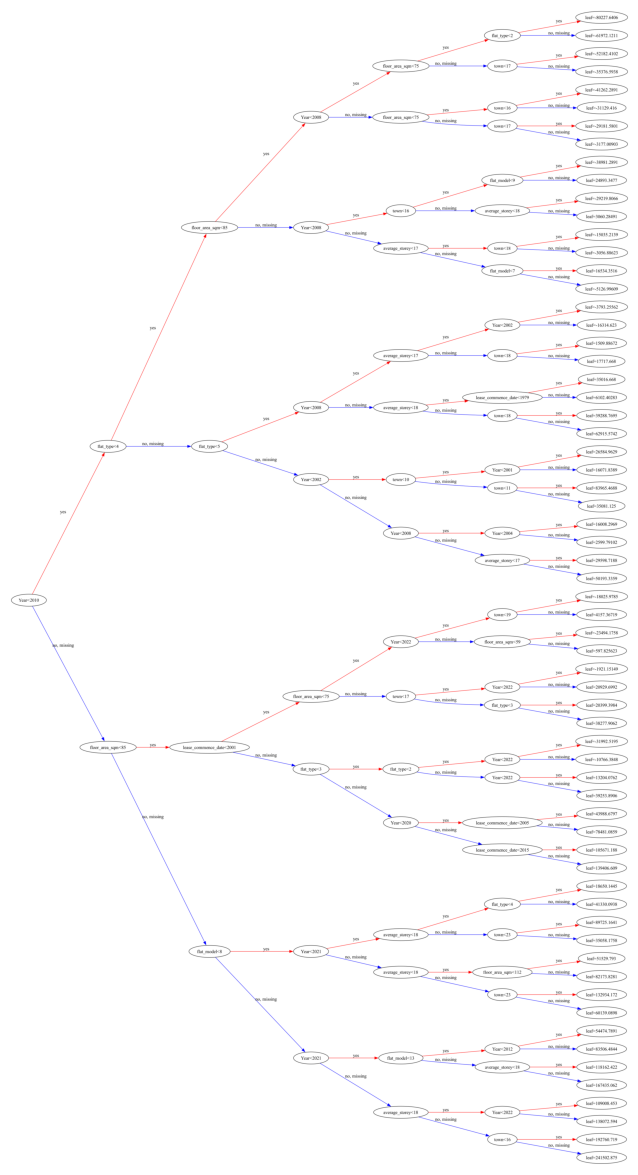

In [45]:
xgb.plot_tree(xgbreg, num_trees=0,rankdir='LR')
plt.show()

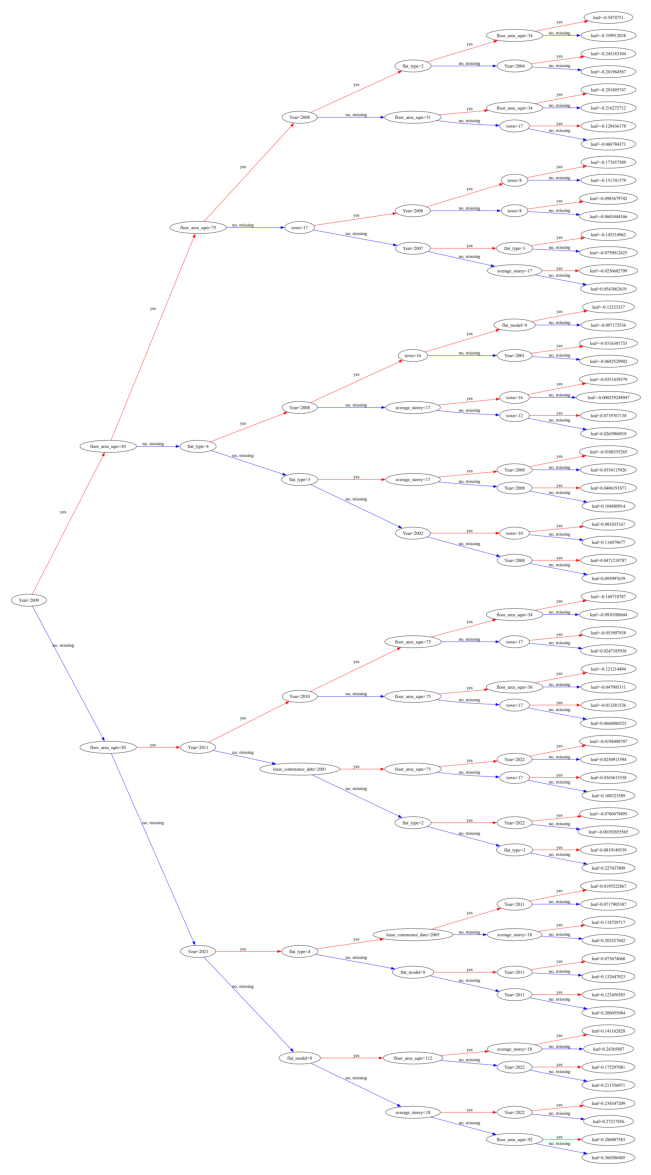

In [47]:
xgb.plot_tree(xgbreg_withLog, num_trees=0,rankdir='LR')
plt.show()

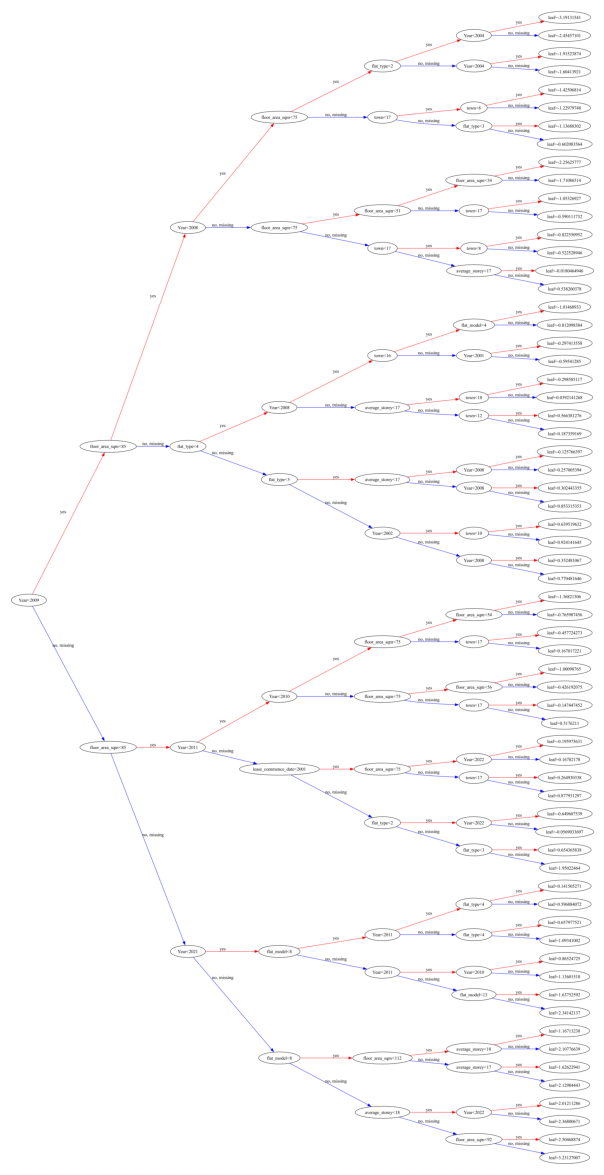

In [46]:
xgb.plot_tree(xgbreg_withBoxCox, num_trees=0,rankdir='LR')
plt.show()

In [130]:
from joblib import dump

#no transformation
dump(linreg, './models/linreg/linreg.joblib')
xgbreg.save_model('./models/xgb/xgb_linreg.json')

#log transformation
dump(linreg_withLog, './models/linreg/linreg_log.joblib')
xgbreg_withLog.save_model('./models/xgb/xgb_linreg_log.json')
tabnetReg_log.save_model('./models/tabnet/tabnet_log')

#boxcox transformation
dump(linreg_withBoxCox, './models/linreg/linreg_boxcox.joblib')
xgbreg_withBoxCox.save_model('./models/xgb/xgb_linreg_box.json')
tabnetReg_box.save_model('./models/tabnet/tabnet_boxcox')


Successfully saved model at ./models/tabnet/tabnet_log.zip
Successfully saved model at ./models/tabnet/tabnet_boxcox.zip


'./models/tabnet/tabnet_boxcox.zip'